 # First raw analysis 

In [1]:
%run 40_testing_different_contrasts.ipynb

data_folder = ..\Psychopy_data\pilot\B_theta_contrast


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier tmp existe d‚j….
Une erreur s'est produite lors du traitement deÿ: tmp.


Writing tmp/40_testing_different_contrats.py


Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier ..\Psychopy_data\pilot\B_theta_contrast existe d‚j….
Une erreur s'est produite lors du traitement deÿ: ..\Psychopy_data\pilot\B_theta_contrast.



 Initializing
B_thetas =  [0.09817477 0.18005332 0.33021925 0.60562477 1.11072073]
contrasts =  [0.1        0.17782794 0.31622777 0.56234133 1.        ]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
subj_name_list =  ['LP', ]
subj_name_list =  ['LP', 'JF']
                
subj_data_list = []
import json
for subject in subj_name_list :
    x = json.load(open(os.path.join(data_folder, 'Psychophys_discrim_%s.json' % subject), 'rb'))
     #changer et mettre le path du fichier où se trouve les psychophysic data
    subj_data_list.append(x)

In [4]:
B_theta_list = []
for x in subj_data_list[0] :
    B_theta_list.append(x[3]*180/np.pi)
B_theta_list = sorted(set(B_theta_list))

print('B_theta_list=', B_theta_list)

contrast_list = []
for x in subj_data_list[0] :
    contrast_list.append(x[4])
contrast_list = sorted(set(contrast_list))
print('contrast_list=', contrast_list)

B_theta_list= [5.625, 10.316295486052553, 18.920169343208578, 34.69974357167867, 63.63961030678928]
contrast_list= [0.1, 0.1778279410038923, 0.31622776601683794, 0.5623413251903491, 1.0]


## Contrast/ B_theta

In [5]:
data_dict = {}

for num, data in enumerate(subj_data_list) :
    data_dict[num] = {}
    N_data = len(data)
    data_dict[num]['theta'] = np.zeros((1, N_data))
    data_dict[num]['conditions'] = np.zeros((1, N_data)).astype(np.int)
    data_dict[num]['response'] = np.zeros((1, N_data))
    for i, item in enumerate(data):
        #print(i, item)
        data_dict[num]['theta'][0, i] = item[1]*180/np.pi
        data_dict[num]['conditions'][0, i] = item[5]+item[6]*len(contrast_list)
        data_dict[num]['response'][0, i] = 1 if item[2] == 'right' else 0


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")

N_conditions = len(contrast_list)*len(B_theta_list)
bias = True
logit0_init, theta0_init, log_wt_init = -np.log(1/.05 - 1), 0.0, np.log(10.)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, logit0_init, theta0_init, log_wt_init, bias=True):
        super(LogisticRegressionModel, self).__init__()
        if bias:
            self.theta0 = torch.nn.Parameter(theta0_init)
        else:
            self.theta0 = theta0_init
        self.logit0 = torch.nn.Parameter(logit0_init)
        self.log_wt = torch.nn.Parameter(log_wt_init)
        self.do_indep = self.logit0.shape.numel() > 1
        
    def forward(self, theta, i_condition):
        if self.do_indep:
            p0 = torch.sigmoid(self.logit0[i_condition.to(int)])
        else:
            p0 = torch.sigmoid(self.logit0)
            
        theta0 = self.theta0[i_condition.to(int)]
        wt = torch.exp(self.log_wt[i_condition.to(int)])
        out = p0 / 2 + (1 - p0) * torch.sigmoid((theta-theta0)/wt)
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 12 + 1

def fit_data(logistic_model,
    theta, ind_condition, y,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.ByteTensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Theta, Ind_condition, labels = Theta.to(device), Ind_condition.to(device), labels.to(device)        
    
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas)
            
    for epoch in range(int(num_epochs)):
        outputs = logistic_model(Theta, Ind_condition)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {loss.item() /len(theta):.5f}")
            losses = []

    logistic_model.eval()
    Theta, Ind_condition, labels = torch.Tensor(theta[:, None]), torch.Tensor(ind_condition[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(Theta, Ind_condition)
    loss = criterion(outputs, labels).item() / len(theta)
    logistic_model = logistic_model.cpu()
    return logistic_model, loss

In [7]:
bias = False
#bias = True
logit0_init = logit0_init * torch.ones(1)
# indep = logit0_init=logit0_init * torch.ones(int(len(data)/len(B_theta_list)/len(contrast_list)))
results = {}
for num, data in enumerate(subj_data_list) :
    logistic_model = LogisticRegressionModel(logit0_init * torch.ones(1), theta0_init*torch.ones(N_conditions), torch.log(log_wt_init*torch.ones(N_conditions)), bias=bias)
    logistic_model, loss = fit_data(logistic_model, data_dict[num]['theta'], 
                                  data_dict[num]['conditions'], 
                                  data_dict[num]['response'], verbose=True)
    results[num] = logistic_model
    print("Final loss =", loss)

Iteration: 0 - Loss: 481.34779
Iteration: 128 - Loss: 384.07032
Iteration: 256 - Loss: 345.08202
Iteration: 384 - Loss: 333.42867
Iteration: 512 - Loss: 329.12838
Iteration: 640 - Loss: 327.06434
Iteration: 768 - Loss: 325.86259
Iteration: 896 - Loss: 325.06734
Iteration: 1024 - Loss: 324.49837
Iteration: 1152 - Loss: 324.07229
Iteration: 1280 - Loss: 323.74451
Iteration: 1408 - Loss: 323.48817
Iteration: 1536 - Loss: 323.28550
Iteration: 1664 - Loss: 323.12399
Iteration: 1792 - Loss: 322.99441
Iteration: 1920 - Loss: 322.88976
Iteration: 2048 - Loss: 322.80467
Iteration: 2176 - Loss: 322.73492
Iteration: 2304 - Loss: 322.67725
Iteration: 2432 - Loss: 322.62908
Iteration: 2560 - Loss: 322.58841
Iteration: 2688 - Loss: 322.55368
Iteration: 2816 - Loss: 322.52367
Iteration: 2944 - Loss: 322.49746
Iteration: 3072 - Loss: 322.47433
Iteration: 3200 - Loss: 322.45373
Iteration: 3328 - Loss: 322.43524
Iteration: 3456 - Loss: 322.41852
Iteration: 3584 - Loss: 322.40333
Iteration: 3712 - Loss: 

In [8]:
results[0].logit0, results[1].logit0

(Parameter containing:
 tensor([-3.0425], requires_grad=True), Parameter containing:
 tensor([-6.1145], requires_grad=True))

In [9]:
def npa2str(npa):
    """
    format a numpy array into a string
    """
    return ', '.join(list(map('{:.3f}'.format, npa)))

def get_params(logistic_model, verbose=False):
    theta0_ = logistic_model.theta0.detach().numpy()
    wt_ = torch.exp(logistic_model.log_wt).detach().numpy()
    p0_ = torch.sigmoid(logistic_model.logit0).detach().numpy()
    N_conditions = wt_.shape[0]
    if verbose:
        #for i_condition in range(N_conditions):
        #    print(f'-> i_condition={i_condition}')
        #    if bias:
        #        print(f"theta0 = {theta0_[i_condition]:.3f}")
        #    print(f"slope = {wt_[i_condition]:.3f}")
        if bias:
            print(f"theta0 = {npa2str(theta0_)}")
        print(f"slope = {npa2str(wt_)}")
        print(f"p0 = {npa2str(p0_)}")
    return theta0_, wt_, p0_

for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)

--> observer num 0
slope = 8.609, 7.053, 6.076, 13.083, 16.263, 4.092, 1.994, 11.192, 32.801, 21.312, 1.187, 4.754, 8.765, 23.673, 167.321, 1.603, 5.436, 6.809, 14.299, 186.646, 0.165, 6.785, 5.747, 15.441, 14.380
p0 = 0.046
--> observer num 1
slope = 2.052, 1.216, 6.506, 10.962, 47.719, 2.052, 4.959, 7.192, 11.728, 21.297, 1.216, 1.216, 4.840, 3.582, 120.117, 3.804, 1.684, 3.140, 11.728, 58.175, 1.216, 1.684, 5.855, 6.971, 120.117
p0 = 0.002


--> observer num 0
--> observer num 1


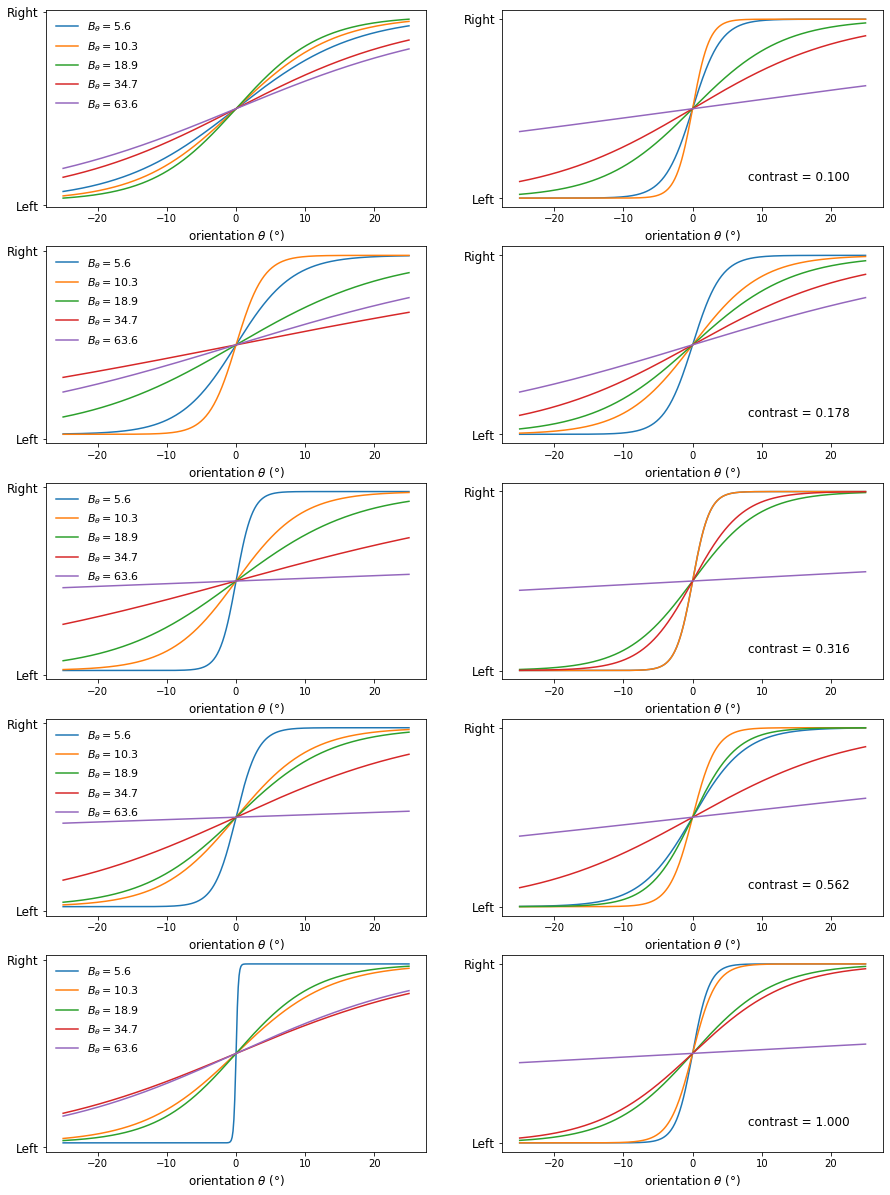

In [12]:
fig, axs = plt.subplots(len(contrast_list), len(subj_data_list), figsize=(15, 21))
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    x_values = np.linspace(-25, 25, 400)

    for i_contrast, contrast in enumerate(contrast_list):
        if len(subj_data_list)>1:
            ax = axs[i_contrast][num]
        else:
            ax = axs[i_contrast]
        #colors = plt.cm.inferno(np.linspace(1, .2, len(B_thetas))) #tc colormap

        for i_B_theta, B_theta in enumerate(B_theta_list):
            i_condition = i_B_theta + i_contrast*len(B_theta_list)
            conditions = i_condition*np.ones_like(x_values)
            y_values = results[num](torch.Tensor(x_values), 
                                      torch.ByteTensor(conditions)).detach().numpy()
            ax.plot(x_values, y_values, label=r'$B_\theta=%s$' % f'{B_theta:.1f}')

        ax.set_xlabel(r"orientation $\theta$ (°)", fontsize=12)
        ax.set_yticks([0.0, 1.0])
        ax.set_yticklabels(["Left", "Right"], fontsize=12)
        if num==0: ax.legend(fontsize=11, frameon=False, scatterpoints=6)
        if num==len(subj_data_list)-1: ax.text(8, 0.1, f'contrast = {contrast:.3f}', fontsize=12)


--> observer num 0
slope = 8.609, 7.053, 6.076, 13.083, 16.263, 4.092, 1.994, 11.192, 32.801, 21.312, 1.187, 4.754, 8.765, 23.673, 167.321, 1.603, 5.436, 6.809, 14.299, 186.646, 0.165, 6.785, 5.747, 15.441, 14.380
p0 = 0.046


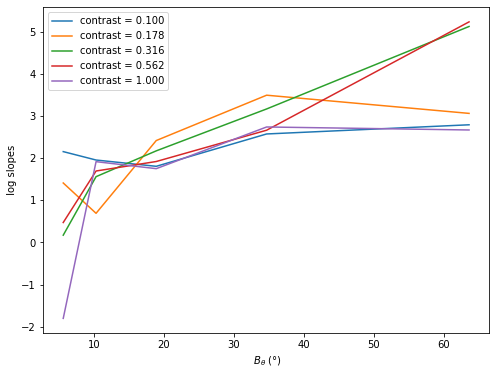

--> observer num 1
slope = 2.052, 1.216, 6.506, 10.962, 47.719, 2.052, 4.959, 7.192, 11.728, 21.297, 1.216, 1.216, 4.840, 3.582, 120.117, 3.804, 1.684, 3.140, 11.728, 58.175, 1.216, 1.684, 5.855, 6.971, 120.117
p0 = 0.002


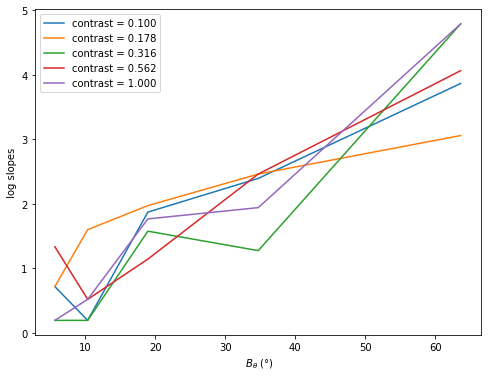

In [27]:
for num, data in enumerate(subj_data_list) :
    print('--> observer num', num)
    theta0_, wt_, p0_ = get_params(results[num], verbose=True)
    coef_list = []
    plt.figure(figsize = (8,6)) 
    for i_contrast, contrast in enumerate(contrast_list):
        wt__ = wt_[(i_contrast*len(contrast_list)):((i_contrast+1)*len(contrast_list))]
        plt.plot(B_theta_list, np.log(wt__), label=f'contrast = {contrast:.3f}')
    plt.xlabel(r' $B_\theta$ (°)')
    plt.ylabel(r' log slopes ')
    plt.legend(loc ='upper left') 
    plt.show()